In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Импорт данных

In [2]:
df = pd.read_csv('./данные для исследований/Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия — Диаграмма.csv', sep=';')

Для библиотеки необходимо определнно назвать столбцы

In [3]:
# Меняем названия столбцов
df.columns = ['unique_id', 'ds', 'y']

# Меняем формат даты
df.ds = pd.to_datetime(df.ds, format='%d.%m.%Y')

# 1. Тестируем GRU, Трансформера и NHITS

на Индикаторе бизнес климата ЦБ

In [65]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MSE
from neuralforecast.models import GRU, NHITS, VanillaTransformer, Informer

In [66]:
horizon = 6     # прогноз на 6 месяцев
lookback = 12   # длина входных данных
maxsteps = 100
learning_rate = 0.001

In [96]:
models = [
    NHITS(
        h=horizon,
        input_size=lookback,
        max_steps=maxsteps,
        scaler_type='standard',
        loss=MSE(),
        learning_rate=learning_rate
    ),
    # Трансформер
    VanillaTransformer(
        h=horizon,
        input_size=lookback,
        hidden_size=12,
        conv_hidden_size=6,
        n_head=2,
        loss=MSE(),
        scaler_type='robust',
        learning_rate=0.001,
        max_steps=700,
        val_check_steps=50,
        early_stop_patience_steps=2
    )
]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=df, val_size=test_size)

Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 36    
4 | dec_embedding | DataEmbedding | 36    
5 | encoder       | TransEncoder  | 1.7 K 
6 | decoder       | TransDecoder  | 1.5 K 
------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [97]:
forecast = nf.predict(df).reset_index()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [98]:
forecast

,unique_id,ds,NHITS,VanillaTransformer
0,62290,2024-06-30,101.690613,102.983765
1,62290,2024-07-31,102.762276,101.651382
2,62290,2024-08-31,104.135857,101.741844
3,62290,2024-09-30,101.697701,102.357391
4,62290,2024-10-31,103.957825,102.907578
5,62290,2024-11-30,101.591316,103.056511


In [100]:
Y_hat_insample = nf.predict_insample(step_size=horizon).reset_index()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [101]:
Y_hat_insample.head(3)

,unique_id,ds,cutoff,NHITS,VanillaTransformer,y
0,62290,2011-10-31,2011-09-30,-0.035219,0.227352,109.900002
1,62290,2011-11-30,2011-09-30,-0.128843,0.213272,104.699997
2,62290,2011-12-31,2011-09-30,-0.094892,0.180989,105.500000


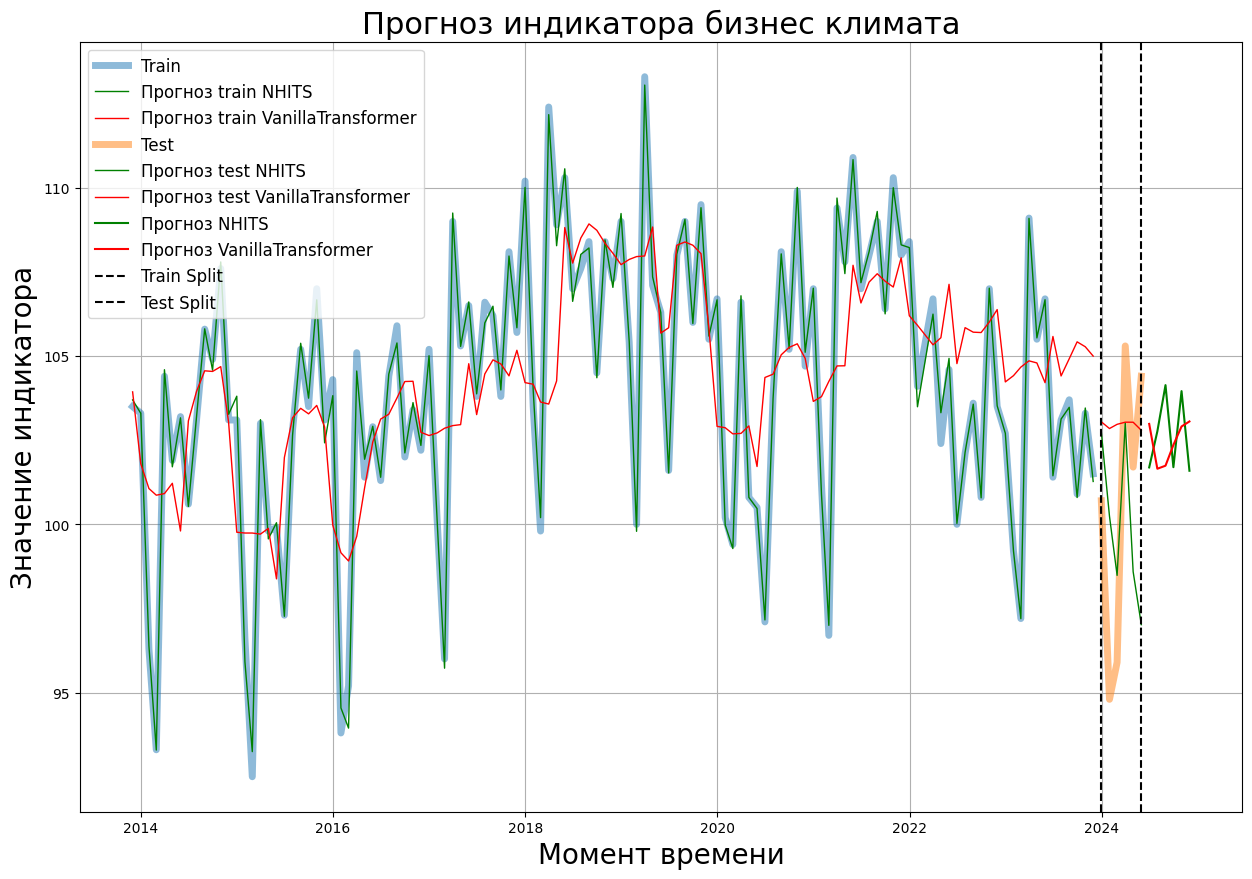

In [105]:
fig, ax = plt.subplots(figsize = (15, 10))

ax.plot(Y_hat_insample.ds[24:-6], Y_hat_insample.y[24:-6], label='Train', linewidth=5, alpha=0.5)
ax.plot(Y_hat_insample.ds[24:-6], Y_hat_insample.NHITS[24:-6], label='NHITS', linewidth=1, color='green')
ax.plot(Y_hat_insample.ds[24:-6], Y_hat_insample.VanillaTransformer[24:-6], label='VanillaTransformer', linewidth=1, color='red')

ax.plot(df.ds[-6:], df.y[-6:], label='Test', linewidth=5, alpha=0.5)
ax.plot(Y_hat_insample.ds[-6:], Y_hat_insample.NHITS[-6:],linewidth=1, color='green')
ax.plot(Y_hat_insample.ds[-6:], Y_hat_insample.VanillaTransformer[-6:],  linewidth=1, color='red')

ax.plot(forecast.ds, forecast.NHITS, label='Прогноз NHITS', color='green')
ax.plot(forecast.ds, forecast.VanillaTransformer, label='Прогноз VanillaTransformer', color='red')

plt.axvline(Y_hat_insample.ds.iloc[-6], color='black', linestyle='--', label='Train Split')
plt.axvline(Y_hat_insample.ds.iloc[-1], color='black', linestyle='--', label='Test Split')

ax.set_title('Прогноз индикатора бизнес климата', fontsize=22)
ax.set_ylabel('Значение индикатора', fontsize=20)
ax.set_xlabel('Момент времени', fontsize=20)

ax.legend(prop={'size': 12})
ax.grid()

# Качество моделей

In [21]:
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

### Обучающая выборка

In [23]:
evaluation_df = evaluate(Y_hat_insample.loc[:, Y_hat_insample.columns != 'cutoff'][:-6], metrics=[rmse, mape])
evaluation_df

,unique_id,metric,NHITS,VanillaTransformer
0,62291,rmse,2.903115,4.903950
1,62291,mape,0.446334,1.105097


### Тестовая выборка

In [24]:
evaluation_df = evaluate(Y_hat_insample.loc[:, Y_hat_insample.columns != 'cutoff'][-6:], metrics=[rmse, mape])
evaluation_df

,unique_id,metric,NHITS,VanillaTransformer
0,62291,rmse,4.204639,4.289526
1,62291,mape,1.437325,1.877404


скорее всего NHITS переобучилась

# 2 Тестируем на других индексах

In [25]:
from datetime import date

In [26]:
date_start = date(year=2015, month=1, day=1)

def data_prerpocess(df):
    """Приводим дату к нужнмоу формату, удаляем лишние столбцы, сортируем по дате, оставим только от 2015 года"""
    
    df.date = pd.to_datetime(df.date, format='%d.%m.%Y')

    df.columns = ['unique_id', 'ds', 'y']
    
    return df

In [27]:
path = './данные для исследований/'

indexes = {
    'Новостной индекс ЦБ': pd.read_csv(path + 'Новостной идекс ЦБ, Россия — Диаграмма.csv', sep=';'),
    'Спрос на промышленность': pd.read_csv(path + 'Оценка изменения спроса на продукцию, товары, услуги (промышленность), пункты, Россия — Диаграмма.csv', sep=';'),
    'ИПЦ': pd.read_csv(path + 'Индекс потребительских цен, Россия — Диаграмма.csv', sep=';'),
    'ИПП': pd.read_csv(path + 'Индекс промышленного производства, Россия — Диаграмма.csv', sep=';'),
    'Оборот розничной торговли': pd.read_csv(path + 'Оборот розничной торговли, Россия — Диаграмма.csv', sep=';'),
    'Погрузка на сети РЖД': pd.read_csv(path + 'Погрузка на сети РЖД, млн тонн, Россия — Диаграмма.csv', sep=';')
}

indexes = {index: data_prerpocess(df) for index, df in indexes.items()}

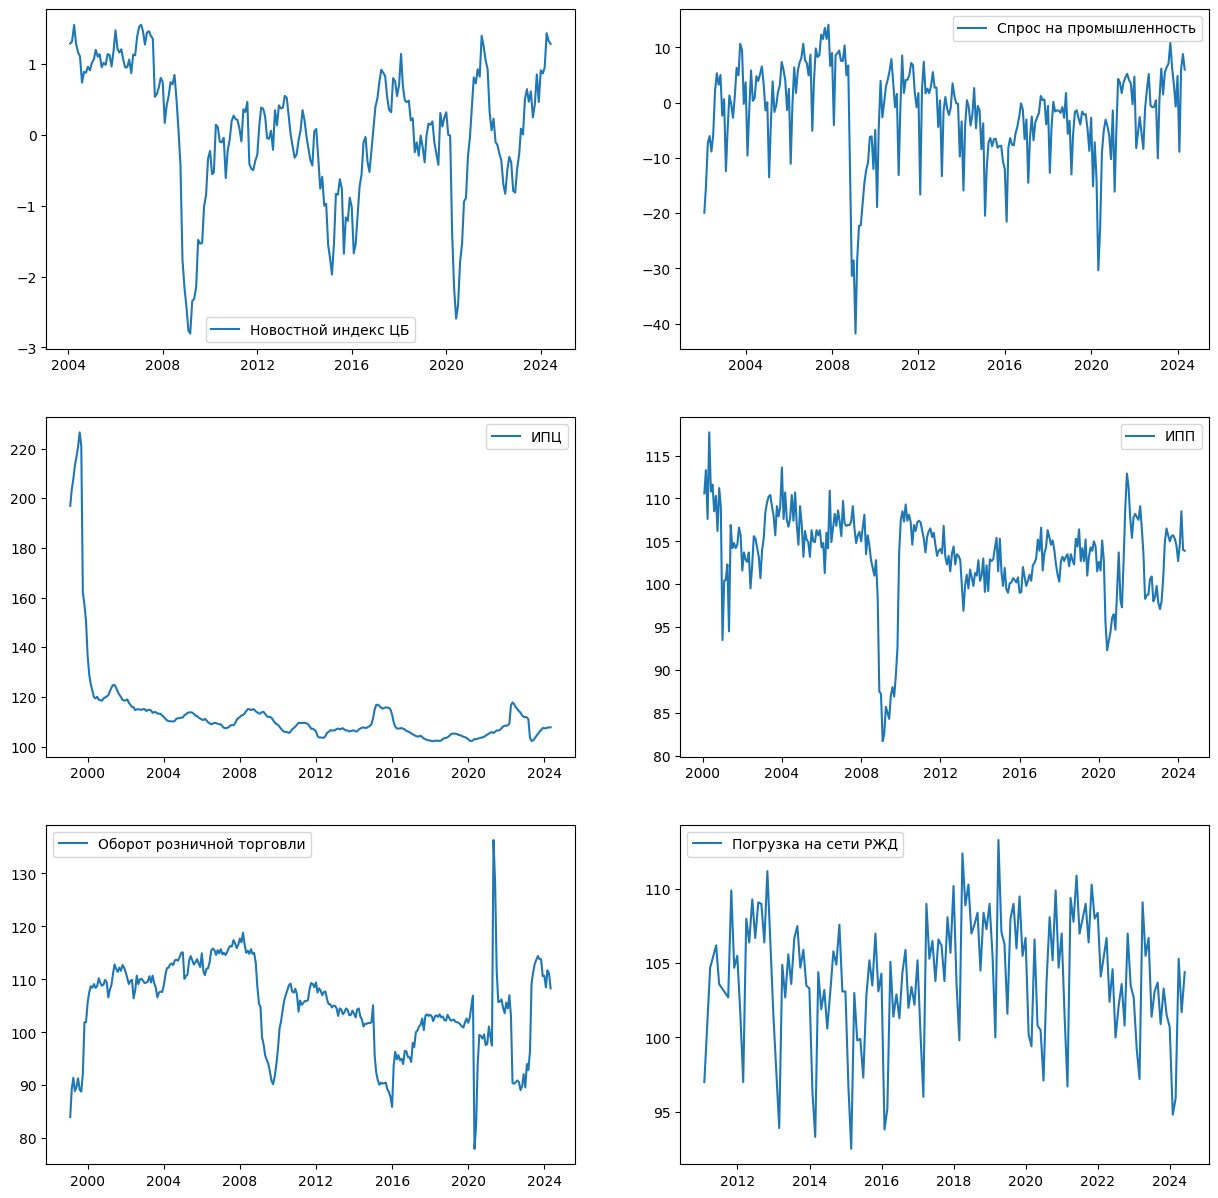

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

k = 0
for i in range(3):
    for j in range(2):
        label, data = list(indexes.items())[k]
        k += 1
                
        axes[i][j].plot(data.ds, data.y, label=label)
        axes[i][j].legend()


# 3. Создание моделей

In [29]:
models = [
    NHITS(
        h=horizon,
        input_size=lookback,
        max_steps=maxsteps,
        scaler_type='standard',
        loss=MSE(),
        learning_rate=learning_rate
    ),
    VanillaTransformer(
        h=horizon,
        input_size=lookback,
        loss=MSE(),
        learning_rate=learning_rate,
        scaler_type='robust',
        hidden_size=8,
        conv_hidden_size=16,
        n_head=2,
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=2
    )
]

Seed set to 1
Seed set to 1


In [30]:
index_models = dict()

In [31]:
for index, df in indexes.items():
    # обучать будем по всем значениям до длины прогноза
    
    nf = NeuralForecast(models=models, freq='M')
    nf.fit(df=df, val_size=horizon)

    # сохраняем модель
    index_models[index] = nf

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.605     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [32]:
results = dict()

for label, df in indexes.items():
        model = index_models[label]
        
        # Прогноз на предыдущее значение
        Y_hat_insample = model.predict_insample(step_size=horizon).reset_index()
        
        # Прогноз на будущее
        predicts = model.predict(df).reset_index()

        results[label] = Y_hat_insample, predicts

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


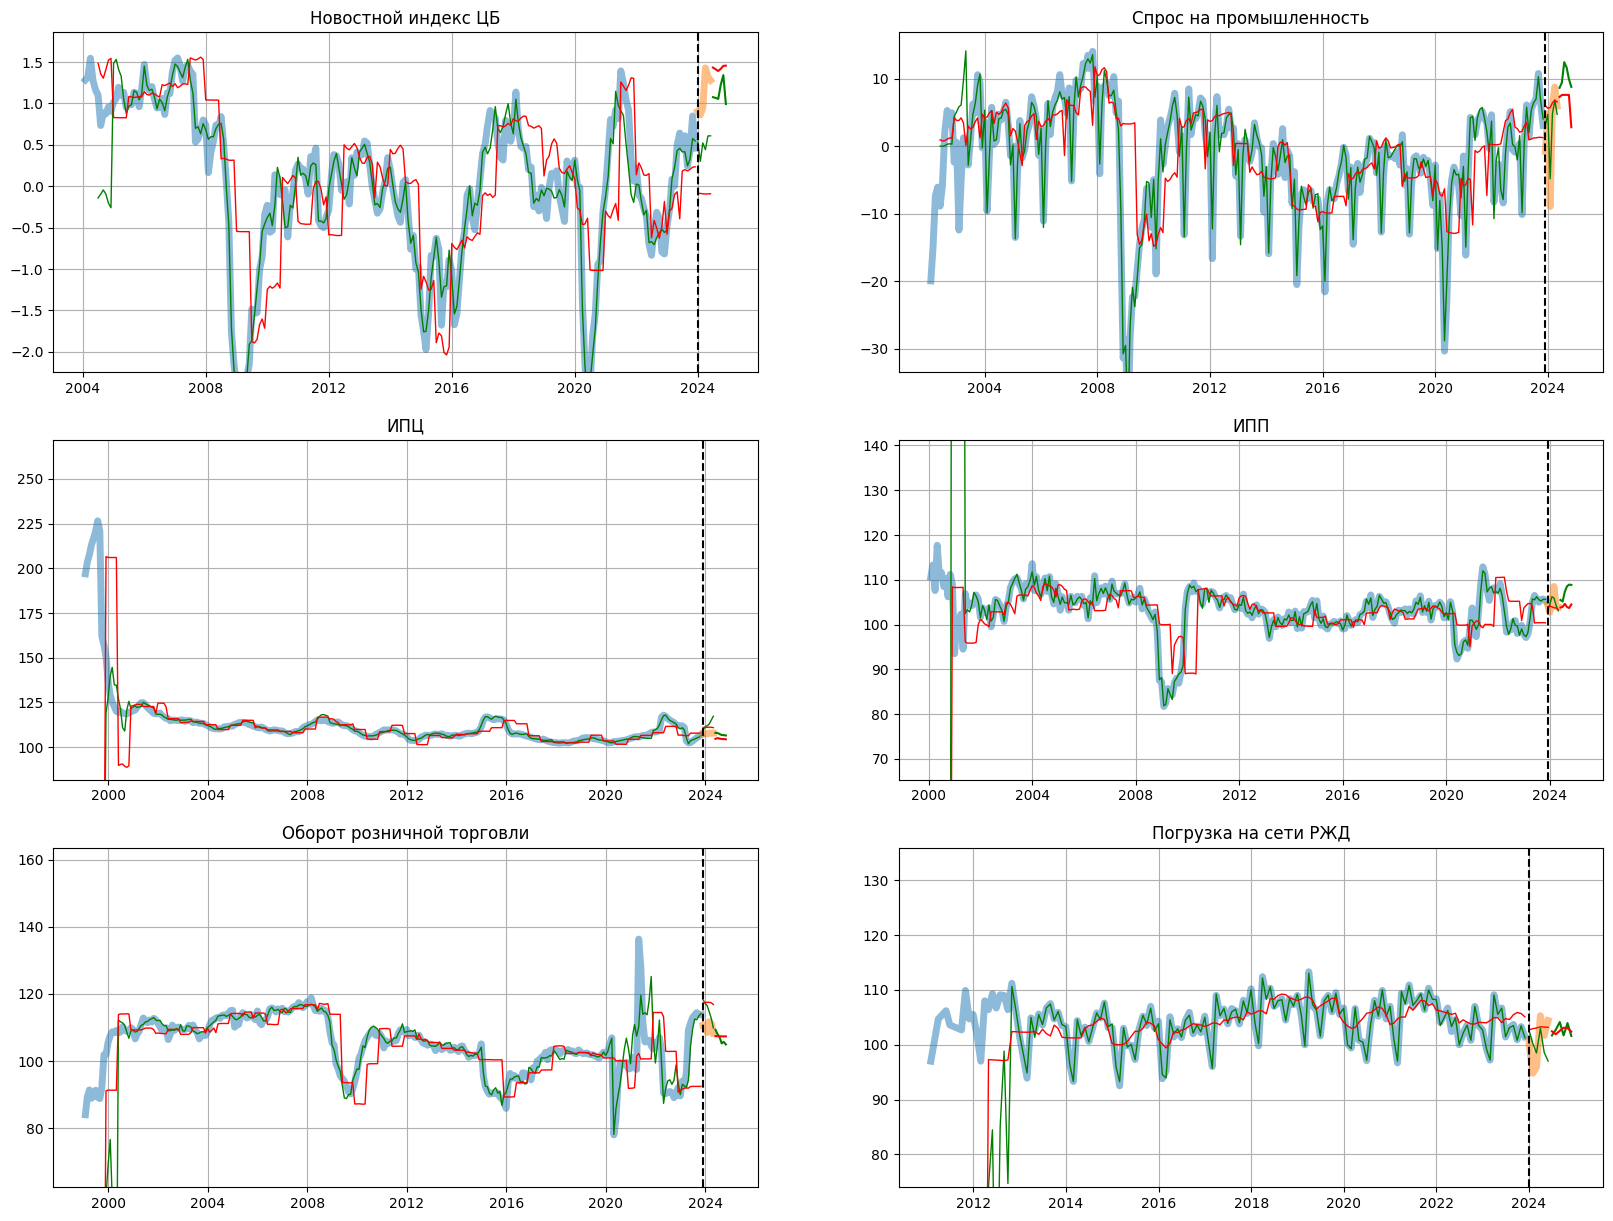

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

k = 0
for i in range(3):
    for j in range(2):
        label, df = list(indexes.items())[k]
        k += 1

        Y_hat_insample, predicts = results[label]

        ymax, ymin = df.y.max(), df.y.min()

        train = Y_hat_insample[:-horizon]
        test = Y_hat_insample[-horizon:]

        axes[i][j].plot(df.ds[:-horizon], df.y[:-horizon], label='Train', linewidth=5, alpha=0.5)
        axes[i][j].plot(train.ds, train.NHITS, label='Train NHITS', linewidth=1, color='green')
        axes[i][j].plot(train.ds, train.VanillaTransformer, label='Train VanillaTransformer', linewidth=1, color='red')

        axes[i][j].plot(df.ds[-horizon:], df.y[-horizon:], label='Test', linewidth=5, alpha=0.5)
        axes[i][j].plot(test.ds, test.NHITS, label='Test NHITS', linewidth=1, color='green')
        axes[i][j].plot(test.ds, test.VanillaTransformer, label='Test VanillaTransformer', linewidth=1, color='red')
      
        axes[i][j].plot(predicts.ds, predicts.NHITS, label='Прогноз NHITS', color='green')
        axes[i][j].plot(predicts.ds, predicts.VanillaTransformer, label='Прогноз VanillaTransformer', color='red')
        
        axes[i][j].axvline(df.ds.iloc[-6], color='black', linestyle='--', label='Train-Test Split')
        
        axes[i][j].set_title(label)

        axes[i][j].set_ylim([0.8 * ymin, 1.2 * ymax])

        # красный - трансформер, зеленый - NHiTS
        # axes[i][j].legend()
        axes[i][j].grid()

# Качество моделей

In [34]:
for index, df in indexes.items():
    df_test = df.iloc[-7:-1]
    Y_hat_insample, predicts = results[index]
    
    train = evaluate(Y_hat_insample.loc[:, Y_hat_insample.columns != 'cutoff'][:-horizon], metrics=[rmse, mape])
    test = evaluate(Y_hat_insample.loc[:, Y_hat_insample.columns != 'cutoff'][-horizon:], metrics=[rmse, mape])
    
    print(
        f'''
        \n---{index}---
        NHITS:
        - train rmse = {train.NHITS[0]:0.2f}
        - test  rmse = {test.NHITS[0]:0.2f}
        - train mape = {train.NHITS[1]:0.2f}
        - test  mape = {test.NHITS[1]:0.2f}

        VanillaTransformer:
        - train rmse = {train.VanillaTransformer[0]:0.2f}
        - test  rmse = {test.VanillaTransformer[0]:0.2f}
        - train mape = {train.VanillaTransformer[1]:0.2f}
        - test  mape = {test.VanillaTransformer[1]:0.2f}
          '''
    )
    


        
---Новостной индекс ЦБ---
        NHITS:
        - train rmse = 0.24
        - test  rmse = 0.65
        - train mape = 1.43
        - test  mape = 0.54

        VanillaTransformer:
        - train rmse = 0.69
        - test  rmse = 1.24
        - train mape = 2.81
        - test  mape = 1.08
          

        
---Спрос на промышленность---
        NHITS:
        - train rmse = 2.25
        - test  rmse = 2.56
        - train mape = 0.73
        - test  mape = 1.10

        VanillaTransformer:
        - train rmse = 7.74
        - test  rmse = 6.65
        - train mape = 2.35
        - test  mape = 1.93
          

        
---ИПЦ---
        NHITS:
        - train rmse = 29.14
        - test  rmse = 5.91
        - train mape = 0.03
        - test  mape = 0.05

        VanillaTransformer:
        - train rmse = 31.67
        - test  rmse = 3.42
        - train mape = 0.05
        - test  mape = 0.03
          

        
---ИПП---
        NHITS:
        - train rmse = 33.19
 